<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Dylan/scikit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#imports
import pandas as pd
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
#Get the filepaths to the csv's we're interested in

root = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/'
files = os.listdir(root)
#spatial_files = [s for s in spatial_files if date_fly in s and '.h5' in s]
filepaths = [root + s for s in files]
filepaths

['/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_1_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_2_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_3_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_4_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_5_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/

In [102]:
#pull in the single framed features
df = pd.concat(map(pd.read_csv, filepaths), ignore_index=True)

#drop duplicates and sample just 5000 obs for speed, need more observations for actually training
df = df.drop(columns = ['Unnamed: 0']).drop_duplicates()
df.head()

,roi_ID,area,center_of_mass_row,center_of_mass_column,resp,stim1,label,frame_number
0,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.244535,-0.700161,tm2,0
1,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.398458,-0.700161,tm2,1
2,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.619290,-0.405675,tm2,2
3,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.627615,0.772268,tm2,3
4,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.611509,0.772268,tm2,4


In [103]:
df['label'].value_counts()

tm2    363853
tm4    207916
t5     103958
tm9     51979
tm1     51979
Name: label, dtype: int64

In [104]:
df['resp_scaled'] = df['resp'] /df['resp'].abs().max()
df['sq_difference'] = (df['resp_scaled']-df['stim1'])**2
#df = df.loc[df['sq_difference'] >.5]

In [105]:
# from imblearn.over_sampling import SMOTE, ADASYN
# X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [106]:
#train test split by roi_ID so that no single roi is included in the training and testing data
#Right now the split is random

rois = df.drop_duplicates('roi_ID')[['roi_ID', 'label']]

X = np.array(rois['roi_ID'])
y = np.array(rois['label'])

#train/test split based on the unique roi ID's, balancing by label
# train_rois, test_rois = train_test_split(
#     rois, test_size=0.3, random_state=101
# )

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

X_train_rois, X_test_rois = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]


TRAIN: [ 80 155  32 131  87 102 144 164 109 157  96 135  22  99 130 156   7  63
  28 152   5   4  71 101  13 103 148 129  67  47 119 124 137   6  15 162
  33 159  56 150 140   1 134   3  12 163 115  93  41  55  25 153 107 116
 120  98  70 139  83  86  39 127 105  54 142 154 123 111  16  92  44  97
  81  46  74  91 108 110 136  45  19  78  49  36  58  62  23  17 132  20
 161  21 100 143  43  29  94  59  65] TEST: [138  53   9  95  90 128 113  61  52  57   8 106   0  66 145 149 104  68
  35  60  75  88  51  89  79  48  40  11  27 160 122  76  50 114  14  69
 126 112 146  10  77  82  85  64  24 133   2  84  72  73  37 125  30 118
 121 158  34  42 117  31  38 147 151 141  26  18]


In [107]:
#use the roi_id's at indexes to split train and test from our full df
X_train = df.query('roi_ID in @X_train_rois')[['sq_difference', 'resp']]
y_train = df.query('roi_ID in @X_train_rois')['label'] 

X_test = df.query('roi_ID in @X_test_rois')[['sq_difference','resp']]
y_test = df.query('roi_ID in @X_test_rois')['label']     

Nearest Neighbors: score: 0.34312574950140123


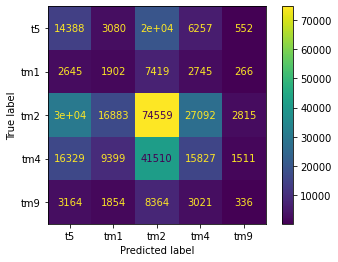

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause



names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=3),
    RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1),
    MLPClassifier(alpha=.01, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


# # preprocess dataset, split into training and test part
# X_train, X_test, y_train, y_test = train_test_split(
#     X_resampled, y_resampled, test_size=0.3, random_state=101
# )

#Scale based on X_train to avoid data leakage
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)


# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f'{name}: score: {score}')

    preds = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()


Elapsed time to compute the importances: 0.817 seconds


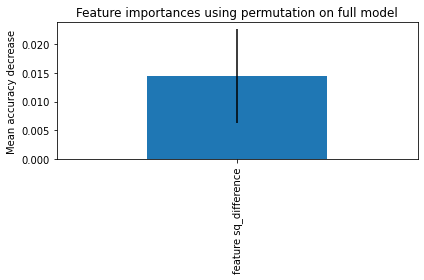

In [ ]:
#useless when there's only 1 feature, but can be useful to see feature importance from RF model

from sklearn.inspection import permutation_importance
import time
feature_names = [f"feature {i}" for i in X_df.columns]
start_time = time.time()
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()